# Problem
The new test for solving pde using pytorch:

$
\frac{\partial{u}}{\partial t} = \kappa (\frac{\partial^2 u}{\partial{x}^2}+\frac{\partial^2 u}{\partial{y}^2}) + S(x,y,t)
$

in the square region $0 \le x \le 2$ and $ 0 \le y \le 2$
for the time $0 \le t \le 2$

Independent variables:
* t - time
* x - coordinate
* y - coordinate

Dependent variables output:
* u - diffusion species

In [92]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from collections import OrderedDict
from torch.autograd import Variable

In [93]:
import numpy as np

In [94]:
batch_size = 4096
block_size = 8
batch_size * block_size

32768

In [95]:
# Select a random subset of the coordinates for the mini-batch
x = torch.arange(0, 0.1 + 0.001, 0.001)
num_samples = x.shape[0]
perm = torch.randperm(num_samples)[:batch_size]
minibatch_coords = x[perm]

In [6]:
minibatch_coords

tensor([0.0290, 0.0700, 0.0160, 0.0750, 0.0760, 0.0430, 0.0670, 0.0720, 0.0630,
        0.0890, 0.0240, 0.0510, 0.0930, 0.0020, 0.0120, 0.0580, 0.0790, 0.0200,
        0.0940, 0.0870, 0.0840, 0.0110, 0.0520, 0.0970, 0.0180, 0.0370, 0.0660,
        0.0480, 0.0390, 0.0280, 0.0090, 0.0620, 0.0740, 0.0770, 0.0310, 0.0830,
        0.0030, 0.0690, 0.0060, 0.0990, 0.0560, 0.0070, 0.0250, 0.0170, 0.0800,
        0.0960, 0.0260, 0.0680, 0.0590, 0.0550, 0.0140, 0.0150, 0.0190, 0.0490,
        0.0450, 0.0860, 0.0500, 0.0230, 0.0920, 0.0400, 0.0220, 0.0710, 0.0980,
        0.0540, 0.0910, 0.0880, 0.0950, 0.1000, 0.0640, 0.0530, 0.0470, 0.0780,
        0.0360, 0.0420, 0.0330, 0.0300, 0.0460, 0.0650, 0.0210, 0.0850, 0.0810,
        0.0570, 0.0000, 0.0100, 0.0380, 0.0730, 0.0900, 0.0410, 0.0050, 0.0040,
        0.0010, 0.0270, 0.0080, 0.0820, 0.0320, 0.0130, 0.0600, 0.0350, 0.0610,
        0.0440, 0.0340])

In [97]:
# rewrite in layer, this is rather boilplate code 
class DiffNet(nn.Module):
    def __init__(self, input_size,hidden_size,
                output_size, depth, act=torch.nn.Tanh):
        super(DiffNet, self).__init__()
        
        layers = [('input', torch.nn.Linear(input_size, hidden_size))]
        layers.append(('input_activation', act()))
        for i in range(depth):
            layers.append(
                ('hidden_%d' %i, torch.nn.Linear(hidden_size, hidden_size))
            )
            layers.append(('activation_%d' %i,act()))
        layers.append(('output', torch.nn.Linear(hidden_size, output_size)))
        
        layerDict = OrderedDict(layers)
        self.layers = torch.nn.Sequential(layerDict)
    
    def forward(self, X):
        out = self.layers(X)
        return out

In [99]:
def get_mgrid(sidelen, dim=2):
    '''Generates a flattened grid of (x,y,...) coordinates in a range of min to max.
    sidelen: int
    dim: int'''
    tensors = tuple(dim * [torch.linspace(0., 0.1, steps=sidelen)])
    mgrid = torch.stack(torch.meshgrid(*tensors), dim=-1)
    mgrid = mgrid.reshape(-1, dim)
    return mgrid

In [100]:
class MyDataset(Dataset):
    def __init__(self, sidelength):
        self.N_src_samples = 1000
        self.velocity = 0.02
        self.r0 = 0.005
        self.source_coords = torch.tensor([0.05,0.05])
        self.coords = get_mgrid(sidelength, 3)
        
    def __len__(self):
        return self.coords.shape[0]
    
    def __getitem__(self,idx):
        N_src_samples = self.N_src_samples
        sample_source_coords = torch.zeros(N_src_samples, 2)
        sample_source_coords_r = 2*self.r0 * torch.rand(N_src_samples,1).sqrt()
        sample_source_coords_theta = 2 * np.pi * torch.rand(N_src_samples, 1)
        sample_source_coords_x = sample_source_coords_r * torch.cos(sample_source_coords_theta) \
                                + self.source_coords[0]
        sample_source_coords_y = sample_source_coords_r * torch.sin(sample_source_coords_theta) \
                                + self.source_coords[1]
        sample_source_coords = torch.cat([sample_source_coords_x, sample_source_coords_y],dim=1)
        
        self.coords[-N_src_samples:, :2] = sample_source_coords
        #print(f"source coords: {sample_source_coords}")
        #print(f"coords: {self.coords[-N_src_samples:,:2]}")
        # self.coords.requires_grad = True
        return self.coords[idx]
        
    

In [101]:
get_mgrid(32,3)[35]

tensor([0.0000, 0.0032, 0.0097])

# Siren implementation
Does implementation for the sine periodic function as described in the paper
""

In [102]:
class SineLayer(torch.nn.Module):
    # See paper sec. 3.2, final paragraph, and supplement Sec. 1.5 for discussion of omega_0.
    
    # If is_first=True, omega_0 is a frequency factor which simply multiplies the activations before the 
    # nonlinearity. Different signals may require different omega_0 in the first layer - this is a 
    # hyperparameter.
    
    # If is_first=False, then the weights will be divided by omega_0 so as to keep the magnitude of 
    # activations constant, but boost gradients to the weight matrix (see supplement Sec. 1.5)
    
    def __init__(self, in_features, out_features, bias=True,
                 is_first=False, omega_0=30):
        super().__init__()
        self.omega_0 = omega_0
        self.is_first = is_first
        
        self.in_features = in_features
        self.linear = nn.Linear(in_features, out_features, bias=bias)
        
        self.init_weights()
    
    def init_weights(self):
        with torch.no_grad():
            if self.is_first:
                self.linear.weight.uniform_(-1 / self.in_features, 
                                             1 / self.in_features)      
            else:
                self.linear.weight.uniform_(-np.sqrt(6 / self.in_features) / self.omega_0, 
                                             np.sqrt(6 / self.in_features) / self.omega_0)
        
    def forward(self, input):
        return torch.sin(self.omega_0 * self.linear(input))
    
    def forward_with_intermediate(self, input): 
        # For visualization of activation distributions
        intermediate = self.omega_0 * self.linear(input)
        return torch.sin(intermediate), intermediate
    
    
class Siren(torch.nn.Module):
    def __init__(self, in_features, hidden_features, hidden_layers, out_features, outermost_linear=False, 
                 first_omega_0=30, hidden_omega_0=30.):
        super().__init__()
        
        self.net = []
        self.net.append(SineLayer(in_features, hidden_features, 
                                  is_first=True, omega_0=first_omega_0))

        for i in range(hidden_layers):
            self.net.append(SineLayer(hidden_features, hidden_features, 
                                      is_first=False, omega_0=hidden_omega_0))

        if outermost_linear:
            final_linear = nn.Linear(hidden_features, out_features)
            
            with torch.no_grad():
                final_linear.weight.uniform_(-np.sqrt(6 / hidden_features) / hidden_omega_0, 
                                              np.sqrt(6 / hidden_features) / hidden_omega_0)
                
            self.net.append(final_linear)
        else:
            self.net.append(SineLayer(hidden_features, out_features, 
                                      is_first=False, omega_0=hidden_omega_0))
        
        self.net = nn.Sequential(*self.net)
    
    def forward(self, coords):
        # coords = coords.clone().detach().requires_grad_(True) # allows to take derivative w.r.t. input
        output = self.net(coords)
        return output       

    def forward_with_activations(self, coords, retain_grad=False):
        '''Returns not only model output, but also intermediate activations.
        Only used for visualizing activations later!'''
        activations = OrderedDict()

        activation_count = 0
        x = coords.clone().detach().requires_grad_(True)
        activations['input'] = x
        for i, layer in enumerate(self.net):
            if isinstance(layer, SineLayer):
                x, intermed = layer.forward_with_intermediate(x)
                
                if retain_grad:
                    x.retain_grad()
                    intermed.retain_grad()
                    
                activations['_'.join((str(layer.__class__), "%d" % activation_count))] = intermed
                activation_count += 1
            else: 
                x = layer(x)
                
                if retain_grad:
                    x.retain_grad()
                    
            activations['_'.join((str(layer.__class__), "%d" % activation_count))] = x
            activation_count += 1

        return activations

## New layer architecture (Giulio)


In [103]:
class ComplexHeatEquationNet(torch.nn.Module):
    def __init__(self):
        super(ComplexHeatEquationNet, self).__init__()
        self.fc1 = torch.nn.Linear(3, 512)
        self.ln1 = torch.nn.LayerNorm(512)
        self.silu1 = torch.nn.SiLU()
        self.fc2 = torch.nn.Linear(512, 256)
        self.ln2 = torch.nn.LayerNorm(256)
        self.silu2 = torch.nn.SiLU()
        self.fc3 = torch.nn.Linear(256, 128)
        self.ln3 = torch.nn.LayerNorm(128)
        self.silu3 = torch.nn.SiLU()
        self.fc4 = torch.nn.Linear(128, 64)
        self.ln4 = torch.nn.LayerNorm(64)
        self.silu4 = torch.nn.SiLU()
        self.fc5 = torch.nn.Linear(64, 32)
        self.ln5 = torch.nn.LayerNorm(32)
        self.silu5 = torch.nn.SiLU()
        self.fc6 = torch.nn.Linear(32, 1)

    def forward(self, X):
        x = self.silu1(self.ln1(self.fc1(X)))
        x = self.silu2(self.ln2(self.fc2(x)))
        x = self.silu3(self.ln3(self.fc3(x)))
        x = self.silu4(self.ln4(self.fc4(x)))
        x = self.silu5(self.ln5(self.fc5(x)))
        x = self.fc6(x)
        return x

Material properties for this case:

In [34]:
ρ = 7860; Cp = 624; k = 30.1
γ = 2.5e+4; P = 1e+5; r0 = 0.005; y_min=0.0; y_max = 0.1; x_min = 0.0; x_max = 0.1;
κ = k/(ρ * Cp)
T0 = 300.0

Differential model for this equation is very similar as for one-dimensional case.
* predict out based on the coordinates $x, y$ and time $t$.

In [180]:
learn_rate = 0.01
class Net:
    def __init__(self, model="diff"):
        device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
        self.device = device
        # build model
        if model == "diff":
            self.model = DiffNet(
                input_size=3,
                hidden_size=128,
                output_size=1,
                depth=5,
                act=torch.nn.Tanh).to(device)
        elif model == "complex":
            self.model = ComplexHeatEquationNet().to(device)
        elif model == "siren":
            self.model = Siren(in_features=3, out_features=1, hidden_features=256, 
                   hidden_layers=5, outermost_linear=True).to(device)
        mydata = MyDataset(256)
        self.dataloader = DataLoader(mydata, batch_size=128, pin_memory=True, num_workers=0, shuffle=True)
        
        # Initial and boundary conditions, we first create the 
        # meshgrid for x and y coordinates. The mesh is regular 
        # grid with h and k steps.
        self.h = 0.002
        self.k = 0.002
        self.dt = 0.002
        
        self.N_src_samples = 100
        self.velocity = 0.02
        self.source_coords = torch.tensor([0.05,0.05])

        x = torch.arange(0, 0.1 + self.h, self.h)
        y = torch.arange(0, 0.1 + self.k, self.k)
        t = torch.arange(0, 0.1 + self.dt, self.dt)
        
        
        xmin_bc = torch.stack(torch.meshgrid(x[0],y,t)).reshape(3,-1).T
        xmax_bc = torch.stack(torch.meshgrid(x[-1],y,t)).reshape(3,-1).T
        ymin_bc = torch.stack(torch.meshgrid(x,y[0],t)).reshape(3,-1).T
        ymax_bc = torch.stack(torch.meshgrid(x,y[-1],t)).reshape(3,-1).T
        #print(f"xmin_bc requires grad: {xmin_bc.is_leaf}")
        ic = torch.stack(torch.meshgrid(x,y,t[0])).reshape(3,-1).T
        
        # make training bcs
        self.bc_train = torch.cat([ic, xmin_bc, xmax_bc, ymin_bc, ymax_bc]) # @ivt note this are all boundary conditions
        # self.bc_train = torch.cat([ic, xmin_bc, xmax_bc, ymin_bc])
        self.bc_train = self.bc_train.to(device)
        #print(f"bc_train : {self.bc_train.shape}")
        
        self.X = torch.stack(torch.meshgrid(x,y,t)).reshape(3,-1).T.to(device)
        N_src_samples = self.N_src_samples
        sample_source_coords = torch.zeros(N_src_samples, 2)
        sample_source_coords_r = r0 * torch.rand(N_src_samples,1).sqrt()
        sample_source_coords_theta = 2 * np.pi * torch.rand(N_src_samples, 1)
        sample_source_coords_x = sample_source_coords_r * torch.cos(sample_source_coords_theta) \
                                + self.source_coords[0]
        sample_source_coords_y = sample_source_coords_r * torch.sin(sample_source_coords_theta) \
                                + self.source_coords[1]
        sample_source_coords = torch.cat([sample_source_coords_x, sample_source_coords_y],dim=1)
        self.X[-self.N_src_samples:, :2] = sample_source_coords
        self.X.requires_grad = True
        #print(f"X shape: {self.X.shape}")
        
        self.all_zeros = torch.zeros_like(self.X).to(device)
        self.all_zeros.requires_grad = False
        
        #initial and boundary condition 
        u_init = torch.zeros(len(ic))
        u_xmin = torch.ones(len(xmin_bc))*T0
        u_xmax = torch.ones(len(xmax_bc))*T0
        u_ymin = torch.ones(len(ymax_bc))*T0
        u_ymax = torch.ones(len(ymin_bc))*T0
        
        self.u_train = torch.cat([u_init, u_xmin, u_xmax, u_ymin, u_ymax])
        # self.u_train = torch.cat([u_init, u_xmin, u_xmax, u_ymin])
        self.u_train = self.u_train.unsqueeze(1)
        self.u_train = self.u_train.to(device)
        
        self.mse_cost_function = nn.MSELoss()
        self.optimizer = torch.optim.LBFGS(self.model.parameters(),lr=learn_rate,max_iter=500,max_eval=50000,
                                  history_size=50,tolerance_grad=1e-5,tolerance_change=1.0 * np.finfo(float).eps)
        self.optimizer_Adam = torch.optim.Adam(self.model.parameters())
        self.iter = 0
        
    def source(self): 
        return 2*P/(torch.pi*r0**2)*torch.exp(-2/(r0**2)*((self.X[:,0]-self.source_coords[0])**2 + (self.X[:,1]-self.source_coords[1])**2))

    def f(self):
        u = self.model(self.X) 
        u_dX = torch.autograd.grad(
            u, self.X, 
            grad_outputs=torch.ones_like(u),
            retain_graph=True,
            create_graph=True
        )[0]
        
        u_x = u_dX[:,0]
        u_y = u_dX[:,1]
        u_t = u_dX[:,2]
        
       
        
        u_dXX = torch.autograd.grad(
            u_dX, self.X, 
            grad_outputs=torch.ones_like(u_dX),
            retain_graph=True,
            create_graph=True
        )[0]
        
        u_xx = u_dXX[:,0]
        u_yy = u_dXX[:,1]
        
        return u_t - κ*u_xx - κ*u_yy - 1/(ρ * Cp) * self.source()
    
    def loss_func(self):
        self.optimizer_Adam.zero_grad()
        # initial and boundary conditions
        out = self.model(self.bc_train)
        mse_u = self.mse_cost_function(out, self.u_train)
        
        # fix condition for PDE
        out = self.f()
        mse_f = self.mse_cost_function(out, torch.zeros_like(out))
    
        #loss = mse_u + mse_u_xmax + mse_u_xmin + mse_u_ymax + mse_u_ymin + mse_f
        loss = mse_f + mse_u
        loss.backward()
        
        if self.iter % 100 == 0:
            print(f" Iter: {self.iter}, loss:{loss.data}")
            
        self.iter += 1
        return loss
    
    def closure(self):
           
        self.optimizer.zero_grad()
        # initial and boundary conditions
        out = self.model(self.bc_train)
        mse_u = self.mse_cost_function(out, self.u_train)
        
        # fix condition for PDE
        out = self.f()
        mse_f = self.mse_cost_function(out, torch.zeros_like(out))
    
        loss = mse_f + mse_u
        loss.backward()
        if self.iter % 100 == 0:
            print(f" LFBGS Iter: {self.iter}, loss:{loss.data}")
            
        self.iter += 1
        return loss

    def train(self,epochs, use_lbfgs = True):
        for epoch in range(epochs):
            self.X = next(iter(self.dataloader))
            # always ensure the source is in the batch
            N_src_samples = self.N_src_samples
            sample_source_coords = torch.zeros(N_src_samples, 2)
            sample_source_coords_r = 2*r0 * torch.rand(N_src_samples,1).sqrt()
            sample_source_coords_theta = 2 * np.pi * torch.rand(N_src_samples, 1)
            sample_source_coords_x = sample_source_coords_r * torch.cos(sample_source_coords_theta) \
                                + self.source_coords[0]
            sample_source_coords_y = sample_source_coords_r * torch.sin(sample_source_coords_theta) \
                                + self.source_coords[1]
            sample_source_coords = torch.cat([sample_source_coords_x, sample_source_coords_y],dim=1)
            self.X[-self.N_src_samples:, :2] = sample_source_coords
            self.X = self.X.to(self.device)
            self.X.requires_grad = True
            self.optimizer_Adam.step(self.loss_func)

        if use_lbfgs:
            self.optimizer.step(self.closure)
        


We now the train the network using first Adam optimizer followed by the LFBGS optimizer.

In [182]:
net = Net(model="siren")
net.train(10000)

 Iter: 0, loss:81083.0625
 Iter: 100, loss:20353608.0
 Iter: 200, loss:11384240734208.0
 Iter: 300, loss:162401303396352.0
 Iter: 400, loss:6.403385209965773e+16
 Iter: 500, loss:1.5917454600647475e+17
 Iter: 600, loss:3.409688293351096e+17
 Iter: 700, loss:1.1946138860204851e+17
 Iter: 800, loss:3.833838991258419e+16
 Iter: 900, loss:2.1271806933467136e+16
 Iter: 1000, loss:1.6297521840128e+16
 Iter: 1100, loss:2.093298555342029e+16
 Iter: 1200, loss:6.922396359458816e+16
 Iter: 1300, loss:1.7402571828232192e+17
 Iter: 1400, loss:2.033727900112388e+18
 Iter: 1500, loss:5.632622147236004e+18
 Iter: 1600, loss:6.289154833832215e+18
 Iter: 1700, loss:5.67977360388155e+18
 Iter: 1800, loss:1.1087143201981596e+19
 Iter: 1900, loss:8.462098773084996e+18
 Iter: 2000, loss:1.0695631300586373e+19
 Iter: 2100, loss:8.002200546976989e+18
 Iter: 2200, loss:1.0542208746581393e+19
 Iter: 2300, loss:1.0207178757505024e+19
 Iter: 2400, loss:1.242418012768279e+19
 Iter: 2500, loss:9.652502629082726e+1

In [183]:
net.train(10000)

 Iter: 10100, loss:1.2397182719174377e+19
 Iter: 10200, loss:1.1819598265987367e+19
 Iter: 10300, loss:1.3672966951603798e+19
 Iter: 10400, loss:1.46168306138402e+19
 Iter: 10500, loss:1.3837219695142371e+19
 Iter: 10600, loss:1.5030218398581654e+19
 Iter: 10700, loss:1.454136233473291e+19
 Iter: 10800, loss:1.391564456101675e+19
 Iter: 10900, loss:1.065347162673093e+19
 Iter: 11000, loss:1.2594672599708991e+19
 Iter: 11100, loss:1.3745896458362552e+19
 Iter: 11200, loss:1.6432608096414597e+19
 Iter: 11300, loss:1.2655044584166916e+19
 Iter: 11400, loss:1.3391214897962942e+19
 Iter: 11500, loss:1.6477400001106936e+19
 Iter: 11600, loss:1.0519492836351541e+19
 Iter: 11700, loss:1.0053148173569884e+19
 Iter: 11800, loss:1.3909769870389543e+19
 Iter: 11900, loss:1.4892616717388743e+19
 Iter: 12000, loss:1.2418339521916043e+19
 Iter: 12100, loss:1.210996829176673e+19
 Iter: 12200, loss:1.1766159801854198e+19
 Iter: 12300, loss:1.563611857471878e+19
 Iter: 12400, loss:1.4662907847625409e+19

mydata: tensor([[0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0008],
        [0.0000, 0.0000, 0.0016],
        ...,
        [0.1000, 0.0984, 0.1000],
        [0.1000, 0.0992, 0.0000],
        [0.1000, 0.0992, 0.0008]])


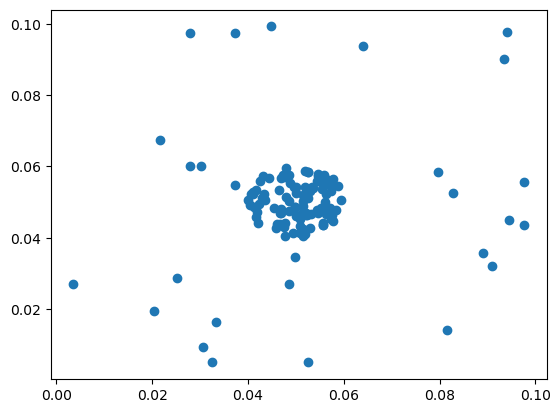

In [174]:
import matplotlib.pyplot as plt
dataloader = DataLoader(mydata, batch_size=128, pin_memory=True, num_workers=0, shuffle=True)
print(f"mydata: {mydata[:-254]}")
#X = next(iter(dataloader))
X = net.X
X = X.detach()
#print(f"returned x: {X}")
x = X[:,0].cpu()
y = X[:,1].cpu()
#x = x.detach().numpy()
#y = y.detach().numpy()
plt.plot(x,y,'o')
plt.show()

In [151]:
net.train(10000)

 Iter: 30000, loss:3171.413818359375
 Iter: 30100, loss:3202.9970703125
 Iter: 30200, loss:41874.5
 Iter: 30300, loss:7022.2314453125
 Iter: 30400, loss:4947.29541015625
 Iter: 30500, loss:3685.453125
 Iter: 30600, loss:4229.5888671875
 Iter: 30700, loss:4151.05224609375
 Iter: 30800, loss:3800.224609375
 Iter: 30900, loss:3642.042236328125
 Iter: 31000, loss:3198.98291015625
 Iter: 31100, loss:2877.612060546875
 Iter: 31200, loss:2892.61181640625
 Iter: 31300, loss:3265.100341796875
 Iter: 31400, loss:3020.883056640625
 Iter: 31500, loss:3787.23388671875
 Iter: 31600, loss:3829.407470703125
 Iter: 31700, loss:3706.70556640625
 Iter: 31800, loss:3094.630859375
 Iter: 31900, loss:3256.26123046875
 Iter: 32000, loss:3300.611083984375
 Iter: 32100, loss:2885.44873046875
 Iter: 32200, loss:4168.060546875
 Iter: 32300, loss:29159.3671875
 Iter: 32400, loss:21468.5703125
 Iter: 32500, loss:21483.162109375
 Iter: 32600, loss:17641.294921875
 Iter: 32700, loss:19965.69921875
 Iter: 32800, loss

In [121]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

Now lets try to plot the current solution of the equation.

shape: (21, 21, 21)


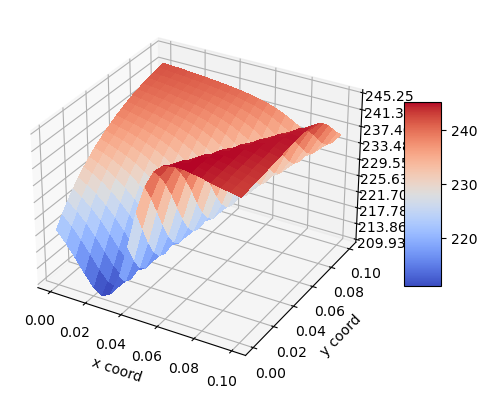

In [178]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter


fig = plt.figure()
ax = plt.axes(projection='3d')
dx = 0.005
x = torch.arange(0,0.1+dx,dx)
y = torch.arange(0,0.1+dx,dx)
t = torch.ones_like(x)*0.04
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
X = torch.stack(torch.meshgrid(x,y,t)).reshape(3,-1).T.to(device)


u_pred = net.model(X)
um = u_pred.data.cpu().numpy()
um = um.reshape(x.shape[0],y.shape[0],t.shape[0])

x = np.arange(0,0.1+dx,dx)
y = np.arange(0,0.1+dx,dx)
xm, ym = np.meshgrid(x,y)

print(f"shape: {um.shape}")

surf = ax.plot_surface(xm, ym, um[:,:,3], cmap=cm.coolwarm, linewidth=0, antialiased=False)

ax.zaxis.set_major_locator(LinearLocator(10))
ax.zaxis.set_major_formatter(FormatStrFormatter('%.02f'))
ax.set_ylabel("y coord")
ax.set_xlabel("x coord")
#ax.view_init(elev=90, azim=-90, roll = 0)
fig.colorbar(surf, shrink=.5, aspect=5)
plt.show()

In [ ]:
def solution(x,y,t):
    return np.exp(x + y) * np.cos(x + y + 4*t)
anal_sol = solution(x,y,2)
mse=np.mean((anal_sol-u_pred.data.cpu().numpy())**2)


In [ ]:
mse

In [ ]:
x.shape[0]

In [ ]:
u_pred.shape